In [1]:
#!pip3 install "psycopg[binary]"

In [2]:
import config
import psycopg
import pytz
import pandas as pd
import numpy as np
from psycopg.rows import dict_row

In [222]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
def pgDictToConn(secretDict):
    pgStrs = []
    for key in secretDict:
        pgStrs.append('{}={}'.format(key, secretDict[key]))
    return ' '.join(pgStrs)


In [4]:
#Init
pgConnStr = pgDictToConn(config.pgSecrets)

In [5]:
def getTicker(symbol):
    with psycopg.connect(pgConnStr) as conn:
        with conn.cursor(row_factory=dict_row) as cur:
            #stmt = '''SELECT * FROM alpaca_minute WHERE symbol = %s'''
            stmt = '''SELECT close FROM alpaca_minute WHERE symbol = %s'''
            data = (symbol, )
            result = cur.execute(stmt, data).fetchall()
            desc = cur.description
            cols = [col[0] for col in desc]
            conn.commit()
    df = pd.DataFrame(data=result, columns=cols)
#     df['datetime'] = df['datetime'].dt.tz_convert('America/New_York')
    df['datetime'] = df['datetime'].dt.tz_convert('America/New_York')
    return df #pd.DataFrame(data=result, columns=cols)

In [205]:
def getFilteredTickerList(lowest_price=0.0, highest_price=999999999):
    with psycopg.connect(pgConnStr) as conn:
        with conn.cursor(row_factory=dict_row) as cur:
            stmt = '''CREATE TEMP TABLE last_tranx 
                ON COMMIT DROP
                AS
                SELECT symbol, max(datetime) AS latest FROM alpaca_minute
                GROUP BY symbol 
                '''
            cur.execute(stmt)
            stmt = '''SELECT AM.symbol FROM alpaca_minute AS AM, last_tranx AS LT
                WHERE AM.symbol = LT.symbol AND AM.datetime = LT.latest
                AND AM.close >= %s AND AM.close <= %s'''
            data = (lowest_price, highest_price)
            result = cur.execute(stmt, data).fetchall()
            conn.commit()
            return [row['symbol'] for row in result]

In [ ]:
###new###
def getDailyTickerList(lowest_price=0.0, highest_price=999999999):
    with psycopg.connect(pgConnStr) as conn:
        with conn.cursor(row_factory=dict_row) as cur:
            stmt = 
            stmt = '''CREATE TEMP TABLE last_tranx 
                ON COMMIT DROP
                AS
                SELECT symbol, max(datetime) AS latest FROM alpaca_minute
                GROUP BY symbol 
                '''
            cur.execute(stmt)
            stmt = '''SELECT AM.symbol FROM alpaca_minute AS AM, last_tranx AS LT
                WHERE AM.symbol = LT.symbol AND AM.datetime = LT.latest
                AND AM.close >= %s AND AM.close <= %s'''
            data = (lowest_price, highest_price)
            result = cur.execute(stmt, data).fetchall()
            conn.commit()
            return [row['symbol'] for row in result]

In [196]:
###new###
def getClosingPrices(symbol):
    with psycopg.connect(pgConnStr) as conn:
        with conn.cursor() as cur:
            stmt = '''SELECT close FROM alpaca_minute WHERE symbol = %s'''
            data = (symbol, )
            cur.execute(stmt, data)
            result = cur.fetchall()
    closing_prices = [row[0] for row in result]
    return closing_prices

In [606]:
###new###
def getDailyPrices(symbol_lst):
    #df = pd.DataFrame(columns=symbol_lst)
    df = pd.DataFrame()

    with psycopg.connect(pgConnStr) as conn:
        with conn.cursor() as cur:
            for symbol in symbol_lst:
                stmt = '''SELECT tranx_date, close FROM alpaca_daily_selected WHERE symbol = %s'''
                data = (symbol, )
                cur.execute(stmt, data)
                rows = cur.fetchall()
                #ticker_df = pd.DataFrame(rows, columns=[symbol])
                ticker_df = pd.DataFrame(rows, columns=['tranx_date',symbol])
                ticker_df.drop_duplicates(subset=['tranx_date']).set_index('tranx_date')   ###alpaca data may have duplicate prices for the same datetime###
                #display(ticker_df)
                df = pd.concat([df, ticker_df[symbol]], axis=1)
                #display(df)
                
    df.to_csv('DailyDF', index=False)

    return df


In [584]:
###new###
def getDailyPricesTickersLst():
    with psycopg.connect(pgConnStr) as conn:
        with conn.cursor() as cur:
            stmt = '''SELECT DISTINCT symbol FROM alpaca_daily_selected'''
            #stmt = '''SELECT COUNT(*) FROM alpaca_daily_selected GROUP BY symbol'''
            #stmt = '''SELECT close FROM alpaca_daily_selected WHERE symbol = %s'''
            #stmt = "SELECT column_name FROM information_schema.columns WHERE table_name = 'alpaca_daily_selected'"
            #stmt = "SELECT table_schema FROM information_schema.tables WHERE table_name = 'alpaca_daily_selected'"
            #data = ('PUBM', )
            #result = cur.execute(stmt, data).fetchall()#, data).fetchall()
            result = cur.execute(stmt).fetchall()
            result = [res[0] for res in result]
    return result

In [586]:
dailyDF = getDailyPrices(getDailyPricesTickersLst())

In [587]:
dailyDF

,IBEX,PUBM,SRDX,SIBN,BIT,CFFE,RMR,SGH,UPBD,EE,...,WMPN,BRDG,EBIX,GPP,AVO,DRQ,MIY,ONYX,RDVT,INBX
0,14.45,29.45,21.20,16.65,16.50,10.03,11.89,13.45,17.17,26.85,...,11.77,15.65,57.10,18.200,21.93,63.28,13.69,9.89,18.70,20.63
1,15.38,27.35,20.60,16.58,16.48,10.03,21.42,13.50,12.64,28.00,...,11.41,15.15,37.02,13.660,21.88,47.75,13.63,9.90,46.40,20.31
2,15.46,25.05,21.01,18.70,16.43,10.04,21.32,13.23,13.08,27.39,...,11.44,15.79,36.72,14.005,22.69,47.85,13.50,9.87,6.20,18.99
3,15.26,24.89,21.55,19.45,16.47,10.04,20.85,45.55,13.50,26.26,...,11.47,15.80,36.56,13.980,22.30,47.30,13.53,9.90,5.73,19.36
4,16.24,23.25,21.45,18.65,16.52,10.04,20.39,47.99,13.21,25.68,...,11.36,15.90,36.72,13.980,22.42,48.25,13.51,9.89,6.10,19.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1837,NaN,NaN,33.20,NaN,15.83,NaN,NaN,NaN,12.28,NaN,...,NaN,NaN,33.90,10.550,NaN,45.45,14.80,NaN,NaN,NaN
1838,NaN,NaN,33.00,NaN,15.87,NaN,NaN,NaN,12.76,NaN,...,NaN,NaN,34.05,11.530,NaN,45.25,14.65,NaN,NaN,NaN
1839,NaN,NaN,33.10,NaN,15.79,NaN,NaN,NaN,12.21,NaN,...,NaN,NaN,33.44,10.100,NaN,44.45,14.50,NaN,NaN,NaN
1840,NaN,NaN,33.20,NaN,15.43,NaN,NaN,NaN,12.31,NaN,...,NaN,NaN,33.01,8.980,NaN,46.10,14.29,NaN,NaN,NaN


In [605]:
###new###
def getFilteredPricesDF(symbol_lst):
    #df = pd.DataFrame(columns=symbol_lst)
    df = pd.DataFrame()

    with psycopg.connect(pgConnStr) as conn:
        with conn.cursor() as cur:
            for symbol in symbol_lst:
                #stmt = '''SELECT datetime, close FROM alpaca_minute WHERE symbol = %s'''
                #stmt = '''SELECT datetime, close FROM alpaca_daily_selected WHERE symbol = %s'''
                data = (symbol, )
                cur.execute(stmt, data)
                rows = cur.fetchall()
                #ticker_df = pd.DataFrame(rows, columns=[symbol])
                ticker_df = pd.DataFrame(rows, columns=['datetime',symbol])
                ticker_df.drop_duplicates(subset=['datetime']).set_index('datetime')   ###alpaca data may have duplicate prices for the same datetime###
                #display(ticker_df)
                df = pd.concat([df, ticker_df[symbol]], axis=1)
                #display(df)
        
    df.to_csv('FilteredClosingDF', index=False)
    
    return df


In [557]:
filtered_dailyDF = getFilteredPricesDF(filtered_symbols)

UndefinedColumn: column "datetime" does not exist
LINE 1: SELECT datetime, close FROM alpaca_daily_selected WHERE symb...
               ^

In [200]:
filtered_symbols = getFilteredTickerList(lowest_price=10.0, highest_price=20.0)

In [352]:
len(filtered_symbols)

2457

In [391]:
FilteredClosingDF = getFilteredPricesDF(filtered_symbols)

In [392]:
FilteredClosingDF.to_csv('FilteredClosingDF', index=False)

In [393]:
len(FilteredClosingDF.columns)

2457

In [394]:
len(FilteredClosingDF.columns.unique())

2457

In [395]:
sum(FilteredClosingDF.columns.duplicated())

0

In [516]:
FilteredClosingDF[good_clusters_dict[7]]

,ACDC,AFCG,AFRM,APP,ARQT,AUDC,BANC,BCBP,BIG,BNKU,...,S,SBNYP,SPXU,SSG,SSL,STER,TSLL,VET,XP,YANG
0,20.370,17.58,24.7900,25.78,18.580,22.300,17.2400,18.220,21.130,27.76,...,28.19,19.1079,17.0800,29.4999,18.49,21.54,26.8100,25.3806,20.145,16.95
1,20.410,17.57,24.6200,25.67,18.570,22.305,17.2512,18.220,21.070,27.73,...,28.09,19.1300,17.1300,29.6300,18.42,21.45,26.7400,25.3800,20.105,17.01
2,20.330,17.58,24.6761,25.64,18.510,22.300,17.2800,18.260,21.100,27.54,...,28.05,19.1100,17.1500,29.6700,18.44,21.42,26.7012,25.3600,20.055,17.01
3,20.295,17.58,24.5600,25.60,18.570,22.250,17.3100,18.214,21.066,27.86,...,27.98,19.2000,17.2066,29.7699,18.43,21.32,26.6793,25.3400,20.010,17.04
4,20.205,17.62,24.6000,25.61,18.605,22.290,17.3100,18.220,21.040,27.86,...,28.02,19.0638,17.1491,29.7699,18.42,21.38,26.6629,25.3000,19.970,17.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [278]:
###new###
def findStockClusters(df, n_clusters):
    
    #need to convert all values to numeric values first
    df = df.apply(pd.to_numeric, errors='coerce')
    
    # Interpolate missing values using linear interpolation
    df = df.interpolate(method='linear', axis=0).ffill().bfill().fillna(0).drop_duplicates()
    
    # Fit KMeans clustering model to the dataframe
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(df.T)   #to find clusters by columns

    # Get cluster labels for each stock
    labels = kmeans.labels_
    
    # Use PCA to reduce the dataframe to 2 dimensions
    pca = PCA(n_components=2)
    coords = pca.fit_transform(df.transpose())

    # Create a dataframe with the stock symbols, their corresponding cluster label, and their 2D coordinates
    clusters = pd.DataFrame({'symbol': df.columns, 'cluster': labels, 'x': coords[:, 0], 'y': coords[:, 1]})

    return clusters


In [592]:
###new###
def plotStockClusters(clusters):
    # Get unique cluster labels
    unique_clusters = np.unique(clusters['cluster'])

    # Create a color map for the clusters
    cmap = plt.get_cmap('viridis', len(unique_clusters))

    # Plot the scatter plot with each cluster colored differently
    fig, ax = plt.subplots(figsize=(8,6))
    for i, cluster in enumerate(unique_clusters):
        x = clusters.loc[clusters['cluster'] == cluster, 'x']
        y = clusters.loc[clusters['cluster'] == cluster, 'y']
        symbol = clusters.loc[clusters['cluster'] == cluster, 'symbol']
        ax.scatter(x, y, label=f"Cluster {cluster}", color=cmap(i))
        for j, sym in enumerate(symbol):
            ax.annotate(sym, (x.iloc[j], y.iloc[j]))

    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    ax.legend()
    plt.show()

In [588]:
#clusters = findStockClusters(FilteredClosingDF, 10)
clusters = findStockClusters(dailyDF, 10)

/Users/thomaskho/Documents/MADS/Capstone/testvenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


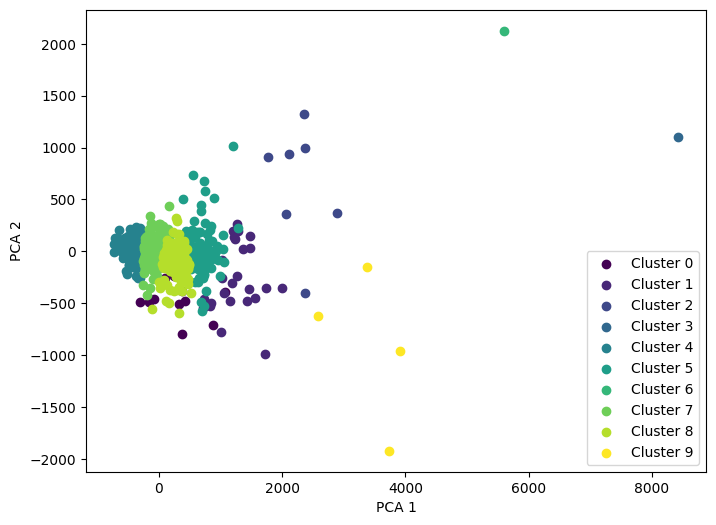

In [591]:
plotStockClusters(clusters)

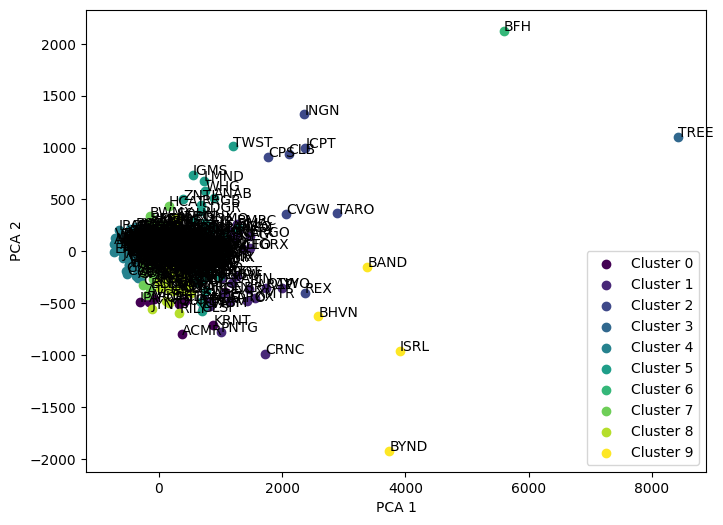

In [593]:
plotStockClusters(clusters)

In [594]:
###new###
def findStocksinClusters(clusters, n):
    good_clusters = []
    good_clusters_dict = {}

    for i in range(n):
        if len(clusters[clusters['cluster']==i]) >= 5:
            good_clusters.append(i)

    for cluster in good_clusters:
        good_clusters_dict[cluster] = clusters[clusters['cluster']==cluster]['symbol'].reset_index()['symbol']

    return good_clusters_dict

In [595]:
good_clusters_dict = findStocksinClusters(clusters, 10)

In [596]:
good_clusters_dict.keys()

dict_keys([0, 1, 2, 4, 5, 7, 8])

In [604]:
good_clusters_dict[0]

0     ARCT
1     KRNT
2     CCRD
3     ACMR
4     ARVN
5      IPI
6     ZUMZ
7     CYRX
8     QTRX
9     CTRN
10    VCEL
11      RM
12    DCPH
13    QURE
14    SNBR
15    BOOM
Name: symbol, dtype: object

In [204]:
def getTickerList():
    with psycopg.connect(pgConnStr) as conn:
        with conn.cursor(row_factory=dict_row) as cur:
            stmt = '''SELECT DISTINCT symbol FROM alpaca_minute ORDER BY symbol'''
            result = cur.execute(stmt).fetchall()
            conn.commit()
            return [row['symbol'] for row in result]

In [206]:
#Count Number of All Tickers
len(getTickerList())

9886

2022-9-15-22-26 to 2023-3-25-4-56

In [533]:
import datetime

In [546]:

with psycopg.connect(pgConnStr) as conn:
    with conn.cursor() as cur:
        stmt = '''SELECT datetime FROM alpaca_minute WHERE symbol = %s AND datetime >= %s'''
        data = ('MSFT', (datetime.datetime.now() - datetime.timedelta(days=20)))#-datetime.timedelta(days=15))
        cur.execute(stmt, data)
        result = cur.fetchall()
len(result)

5384

In [207]:
#Count Tickers Between 10 USD and 30 USD at latest close price
len(getFilteredTickerList(lowest_price=10.0, highest_price=20.0))

KeyboardInterrupt: 

In [ ]:
###test###
def getTest():
    with psycopg.connect(pgConnStr) as conn:
        with conn.cursor(row_factory=dict_row) as cur:
            #stmt = '''SELECT DISTINCT symbol FROM alpaca_minute ORDER BY symbol'''
            #stmt = '''SELECT * FROM alpaca_minute LIMIT 20'''
            
            #stmt = '''SELECT column_name, data_type FROM information_schema.columns WHERE table_name = %s'''
            #result = cur.execute(stmt, ('alpaca_minute',)).fetchall()
            
            #stmt = '''SELECT close FROM alpaca_minute WHERE symbol IN (%s, %s) ORDER BY datetime DESC LIMIT 10'''

            #stmt = "SELECT column_name FROM information_schema.columns WHERE table_name = 'alpaca_minute'"
            #stmt = "SELECT table_schema FROM information_schema.tables WHERE table_name = 'alpaca_minute'"
            #result = cur.execute(stmt).fetchall()
            
                        
            stmt = """
            SELECT microsoft.datetime, microsoft.close AS microsoft_close, apple.close AS apple_close
            FROM public.alpaca_minute AS microsoft
            JOIN public.alpaca_minute AS apple ON microsoft.datetime = apple.datetime
            WHERE microsoft.symbol = 'MSFT' AND apple.symbol = 'AAPL'
            ORDER BY microsoft.datetime DESC
            LIMIT 10;
            """
            result = cur.execute(stmt).fetchall()
            
            #stmt = "SELECT datetime, close as Microsoft FROM public.alpaca_minute WHERE symbol = %s ORDER BY datetime DESC LIMIT 10"
            #result = cur.execute(stmt, ('MSFT',)).fetchall()
            
            #stmt = "SELECT datetime, close as Apple FROM public.alpaca_minute WHERE symbol = %s ORDER BY datetime DESC LIMIT 10"
            #result = cur.execute(stmt, ('AAPL',)).fetchall()
            

            #stmt = '''SELECT alpaca_minute.close, COUNT(*) FROM alpaca_minute WHERE symbol = %s GROUP BY alpaca_minute.close'''
            #result = cur.execute(stmt, ('MSFT','AAPL')).fetchall()
            #result = cur.execute(stmt).fetchall()
            #result = cur.execute(stmt, ('MSFT',)).fetchall()
            
            conn.commit()
            #return [row['symbol'] for row in result]
            return result

In [ ]:
#MSFT
getTest()

[{'datetime': datetime.datetime(2023, 3, 25, 4, 56, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'microsoft': 280.73},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 55, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'microsoft': 280.8577},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 53, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'microsoft': 280.86},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 52, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'microsoft': 280.71},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 51, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'microsoft': 280.93},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 50, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'microsoft': 280.56},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 49, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'microsoft': 280.48},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 48, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'microsoft': 280.37},
 {'dat

In [ ]:
#AAPL
getTest()

[{'datetime': datetime.datetime(2023, 3, 25, 4, 56, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'apple': 160.26},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 55, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'apple': 160.31},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 54, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'apple': 160.31},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 52, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'apple': 160.3},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 51, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'apple': 160.37},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 50, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'apple': 160.23},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 49, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'apple': 160.24},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 48, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'apple': 160.21},
 {'datetime': datetime.datetime(2023, 3, 

In [ ]:
#MSFT & AAPL
getTest()

[{'datetime': datetime.datetime(2023, 3, 25, 4, 56, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'microsoft_close': 280.73,
  'apple_close': 160.26},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 55, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'microsoft_close': 280.8577,
  'apple_close': 160.31},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 52, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'microsoft_close': 280.71,
  'apple_close': 160.3},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 51, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'microsoft_close': 280.93,
  'apple_close': 160.37},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 50, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'microsoft_close': 280.56,
  'apple_close': 160.23},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 49, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'microsoft_close': 280.48,
  'apple_close': 160.24},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 48, tzinfo=zoneinfo.Z

In [ ]:
#Horris's code. Show every minute. If it's zero for that minute, it'll show as zero.
stmt = '''SELECT datetime,
        SUM(CASE symbol
        WHEN 'MSFT' THEN close
            ELSE 0
        END) "MSFT Close",
        SUM(CASE symbol
        WHEN 'AAPL' THEN close
            ELSE 0 
        END) "AAPL Close"
    FROM alpaca_minute
    WHERE symbol = 'MSFT' or symbol = 'AAPL'
    GROUP BY datetime
    ORDER BY datetime DESC LIMIT 10'''

with psycopg.connect(pgConnStr) as conn:
    with conn.cursor(row_factory=dict_row) as cur:
        result = cur.execute(stmt).fetchall()

result

[{'datetime': datetime.datetime(2023, 3, 25, 4, 56, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'MSFT Close': 280.73,
  'AAPL Close': 160.26},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 55, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'MSFT Close': 280.8577,
  'AAPL Close': 160.31},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 54, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'MSFT Close': 0.0,
  'AAPL Close': 160.31},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 53, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'MSFT Close': 280.86,
  'AAPL Close': 0.0},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 52, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'MSFT Close': 280.71,
  'AAPL Close': 160.3},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 51, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'MSFT Close': 280.93,
  'AAPL Close': 160.37},
 {'datetime': datetime.datetime(2023, 3, 25, 4, 50, tzinfo=zoneinfo.ZoneInfo(key='Asia/Shanghai')),
  'MSFT Clo

In [ ]:
#Get List of All Tickers
#print(getTickerList())

['AAC', 'AACG', 'AACI', 'AACIU', 'AAC.U', 'AADI', 'AADR', 'AAIC', 'AAIC.PRB', 'AAIC.PRC', 'AAIN', 'AAL', 'AAME', 'AAM.PRA', 'AAM.PRB', 'AAN', 'AAOI', 'AAON', 'AAP', 'AAPB', 'AAPD', 'AAPL', 'AAPU', 'AAT', 'AAWW', 'AAXJ', 'AB', 'ABB', 'ABBV', 'ABC', 'ABCB', 'ABCL', 'ABCM', 'ABEO', 'ABNB', 'ABOS', 'ABR', 'ABR.PRD', 'ABR.PRE', 'ABR.PRF', 'ABSI', 'ABST', 'ABT', 'ABUS', 'ABVC', 'AC', 'ACA', 'ACAB', 'ACABU', 'ACAC', 'ACACU', 'ACAD', 'ACAH', 'ACAHU', 'ACAX', 'ACAXR', 'ACAXU', 'ACB', 'ACBA', 'ACBAU', 'ACCD', 'ACCO', 'ACDC', 'ACEL', 'ACER', 'ACET', 'ACGL', 'ACGLN', 'ACGLO', 'ACGN', 'ACHC', 'ACHL', 'ACHR', 'ACHV', 'ACI', 'ACIU', 'ACIW', 'ACLS', 'ACLX', 'ACM', 'ACMR', 'ACN', 'ACNB', 'ACNT', 'ACON', 'ACRE', 'ACR.PRD', 'ACT', 'ACTG', 'ADC.PRA', 'ADNT', 'ADX', 'ADXN', 'AEE', 'AESI', 'AEYE', 'AEZS', 'AFARU', 'AGL', 'AGZD', 'AHG', 'AHT.PRD', 'AIBBR', 'AIF', 'AIG', 'AIR', 'AJRD', 'AKTS', 'ALBT', 'ALDX', 'ALG', 'ALIT', 'ALK', 'ALLE', 'ALLG', 'ALL.PRH', 'ALL.PRI', 'ALLR', 'ALR', 'ALRN', 'ALSN', 'ALTG', 'A

In [ ]:
#Sample 10 random stocks
tickers = getTickerList()
random_pick= list(np.random.choice(tickers, 10 if len(tickers) > 10 else  len(tickers), replace=False))
random_pick

['GNSS',
 'SF',
 'GSQB.U',
 'GTEC',
 'GNL.PRB',
 'GSBD',
 'AAPL',
 'GNPX',
 'GSUN',
 'GNT.PRA']

In [ ]:
getTicker(random_pick[0])

,id,date,symbol,open,close,high,low,trade_count,vol,vwap,datetime
0,286908,2022-09-15,GNSS,3.1851,3.1851,3.1851,3.1851,1.0,335.0,3.185100,2022-09-15 10:39:00-04:00
1,286909,2022-09-15,GNSS,3.1350,3.1350,3.1350,3.1350,2.0,1253.0,3.135156,2022-09-15 11:12:00-04:00
2,286910,2022-09-15,GNSS,3.1050,3.1050,3.1050,3.1050,2.0,104.0,3.105000,2022-09-15 11:24:00-04:00
3,286911,2022-09-15,GNSS,3.0300,3.0300,3.0300,3.0300,1.0,100.0,3.030000,2022-09-15 12:32:00-04:00
4,286912,2022-09-15,GNSS,3.0000,3.0000,3.0000,3.0000,2.0,104.0,3.000962,2022-09-15 12:54:00-04:00
...,...,...,...,...,...,...,...,...,...,...,...
3893,290801,2023-03-13,GNSS,3.4500,3.4500,3.4500,3.4500,6.0,235.0,3.450308,2023-03-13 15:55:00-04:00
3894,290802,2023-03-13,GNSS,3.4700,3.4700,3.4700,3.4700,2.0,120.0,3.469836,2023-03-13 15:56:00-04:00
3895,290803,2023-03-13,GNSS,3.4500,3.4500,3.4500,3.4500,4.0,247.0,3.450000,2023-03-13 15:57:00-04:00
3896,290804,2023-03-13,GNSS,3.4500,3.4500,3.4500,3.4500,8.0,328.0,3.450030,2023-03-13 15:59:00-04:00


In [ ]:
#Get Specific Ticker
AAPL = getTicker('AAPL')

In [ ]:
AAPL.loc[390,:]

id                                   393
date                          2022-09-15
symbol                              AAPL
open                              151.89
close                             151.73
high                              151.89
low                               151.73
trade_count                        163.0
vol                              20313.0
vwap                          151.822464
datetime       2022-09-15 16:56:00-04:00
Name: 390, dtype: object